# Exploratory Data Analysis - ACN Dataset


In [2]:
# Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

In [3]:
ev_json = json.load(open('./Datasets/acndata_sessions_CalTech.json','r'))
ev_df = pd.DataFrame(ev_json['_items'])
ev_df.drop(ev_df.index[ev_df['doneChargingTime'].values==None],inplace=True)
ev_df.reset_index(inplace=True,drop=True)

In [4]:
ev_df[['connectionTime','disconnectTime','doneChargingTime']] = ev_df[['connectionTime','disconnectTime','doneChargingTime']].apply(pd.to_datetime)

In [5]:
ev_df.drop(columns=['_id','clusterID','sessionID',
                    'timezone','userInputs','userID'],inplace=True)

In [12]:
ev_df['chargeTime'] = (ev_df['doneChargingTime'] - ev_df['connectionTime']).values.astype(float)/(36*1e11)
ev_df['parkTime'] = (ev_df['disconnectTime'] - ev_df['connectionTime']).values.astype(float)/(36*1e11)

In [24]:
ev_df.tail()

,disconnectTime,doneChargingTime,kWhDelivered,siteID,spaceID,stationID,chargeTime,parkTime,chargeRate
connectionTime,,,,,,,,,
2021-05-01 00:12:07+00:00,2021-05-01 05:04:23+00:00,2021-05-01 05:04:19+00:00,33.313,0002,CA-319,2-39-95-27,4.870000,4.871111,6.840452
2021-05-01 19:01:17+00:00,2021-05-01 19:16:04+00:00,2021-05-01 19:15:54+00:00,0.905,0002,CA-327,2-39-79-379,0.243611,0.246389,3.714937
2021-05-01 19:55:08+00:00,2021-05-02 01:33:15+00:00,2021-05-01 20:26:03+00:00,0.732,0002,CA-327,2-39-79-379,0.515278,5.635278,1.420593
2021-05-01 20:02:06+00:00,2021-05-01 21:40:51+00:00,2021-05-01 20:31:31+00:00,1.188,0002,CA-316,2-39-90-26,0.490278,1.645833,2.423116
2021-05-01 21:56:16+00:00,2021-05-01 22:40:48+00:00,2021-05-01 22:40:43+00:00,2.476,0002,CA-311,2-39-125-21,0.740833,0.742222,3.342182


In [14]:
ev_df['chargeRate'] = ev_df['kWhDelivered']/ev_df['chargeTime']

In [15]:
ev_df = ev_df.set_index('connectionTime')

<AxesSubplot:xlabel='connectionTime'>

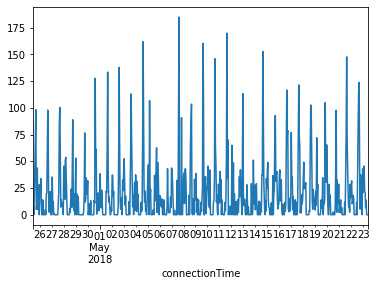

In [84]:
ev_df_quarterly = ev_df.resample('H').sum()
ev_df_quarterly.kWhDelivered.head(24*7*4).plot()

In [20]:
ev_df_quarterly.head()

,kWhDelivered,chargeTime,parkTime,chargeRate
connectionTime,,,,
2018-04-25 11:00:00+00:00,7.932,2.218333,2.201667,3.575657
2018-04-25 11:15:00+00:00,0.000,0.000000,0.000000,0.000000
2018-04-25 11:30:00+00:00,0.000,0.000000,0.000000,0.000000
2018-04-25 11:45:00+00:00,0.000,0.000000,0.000000,0.000000
2018-04-25 12:00:00+00:00,0.000,0.000000,0.000000,0.000000


In [86]:
data = pd.DataFrame(ev_df_quarterly[['kWhDelivered','parkTime']],index=ev_df_quarterly.index)

Text(0, 0.5, 'Dwelling time in the parking station [hour]')

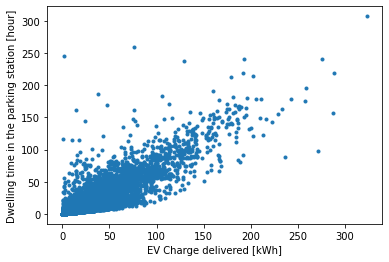

In [93]:
plt.scatter(data['kWhDelivered'],data['parkTime'],marker='.')
plt.xlabel('EV Charge delivered [kWh]')
plt.ylabel('Dwelling time in the parking station [hour]')
plt.show()

<AxesSubplot:xlabel='connectionTime'>

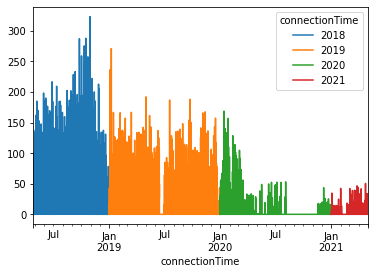

In [122]:
ev_pvt = pd.pivot_table(ev_df_quarterly, index= ev_df_quarterly.index, columns=ev_df_quarterly.index.year,values='kWhDelivered')
ev_pvt.plot()

<AxesSubplot:xlabel='connectionTime'>

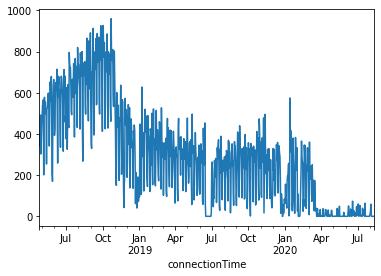

In [113]:
data.kWhDelivered.resample('1D').sum().head(60*14).plot()

In [103]:
from statsmodels.graphics.tsaplots import plot_acf


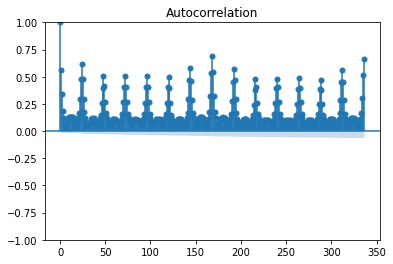

In [127]:
fig, axe = plt.subplots()
acf_plt = plot_acf(data.kWhDelivered,ax = axe, lags=24*14)

In [110]:
# Adding sin/cos values to the dataset
data['hour_x'] = np.sin(np.radians((360/24)*data.index.hour))
data['hour_y'] = np.cos(np.radians((360/24)*data.index.hour))

data['month_x'] = np.sin(np.radians((360/12)*data.index.month))
data['month_y'] = np.cos(np.radians((360/12)*data.index.month))


MAX_LAG = 24
for lag in range(1,MAX_LAG+1):
    data['charge_lag_'+str(lag)] = data.kWhDelivered.shift(lag)

In [111]:
data['day_of_week'] = data.index.weekday
data['hour_of_day'] = data.index.hour
data['month_of_year'] = data.index.month
data['weekend'] = data.index.weekday.isin([5,6])

data = pd.get_dummies(data, columns=['day_of_week','hour_of_day','month_of_year'])

In [112]:
data.head(25)

,kWhDelivered,parkTime,hour_x,hour_y,month_x,month_y,charge_lag_1,charge_lag_2,charge_lag_3,charge_lag_4,...,month_of_year_3,month_of_year_4,month_of_year_5,month_of_year_6,month_of_year_7,month_of_year_8,month_of_year_9,month_of_year_10,month_of_year_11,month_of_year_12
connectionTime,,,,,,,,,,,,,,,,,,,,,
2018-04-25 11:00:00+00:00,7.932,2.201667,2.588190e-01,-9.659258e-01,0.866025,-0.5,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,0,0,0,0
2018-04-25 12:00:00+00:00,0.000,0.000000,1.224647e-16,-1.000000e+00,0.866025,-0.5,7.932,NaN,NaN,NaN,...,0,1,0,0,0,0,0,0,0,0
2018-04-25 13:00:00+00:00,15.270,20.500278,-2.588190e-01,-9.659258e-01,0.866025,-0.5,0.000,7.932,NaN,NaN,...,0,1,0,0,0,0,0,0,0,0
2018-04-25 14:00:00+00:00,45.453,36.049722,-5.000000e-01,-8.660254e-01,0.866025,-0.5,15.270,0.000,7.932,NaN,...,0,1,0,0,0,0,0,0,0,0
2018-04-25 15:00:00+00:00,69.505,114.189167,-7.071068e-01,-7.071068e-01,0.866025,-0.5,45.453,15.270,0.000,7.932,...,0,1,0,0,0,0,0,0,0,0
2018-04-25 16:00:00+00:00,98.398,57.446944,-8.660254e-01,-5.000000e-01,0.866025,-0.5,69.505,45.453,15.270,0.000,...,0,1,0,0,0,0,0,0,0,0
2018-04-25 17:00:00+00:00,5.070,9.075833,-9.659258e-01,-2.588190e-01,0.866025,-0.5,98.398,69.505,45.453,15.270,...,0,1,0,0,0,0,0,0,0,0
2018-04-25 18:00:00+00:00,8.712,78.856944,-1.000000e+00,-1.836970e-16,0.866025,-0.5,5.070,98.398,69.505,45.453,...,0,1,0,0,0,0,0,0,0,0
2018-04-25 19:00:00+00:00,43.732,21.155278,-9.659258e-01,2.588190e-01,0.866025,-0.5,8.712,5.070,98.398,69.505,...,0,1,0,0,0,0,0,0,0,0
